In [1]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

Using TensorFlow backend.
/phys/users/brycek/.conda/envs/py3-bryce/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/phys/users/brycek/.conda/envs/py3-bryce/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/phys/users/brycek/.conda/envs/py3-bryce/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/p

from keras.models import Sequential
from keras.layers import Dense
from keras.utils import to_categorical

## Make training set

### False Dataset

Our false data is a set of postage stamps actually collected from KBMOD that were false positives coming through the pipeline. These were obtained when recovering known objects in Pointing Group 010 to 089 in the Lori Allen NEO dataset

In [3]:
full_false = np.load('/epyc/users/smotherh/kbmod_epyc/notebooks/stamp_training_set.npy')

### Make real dataset

Make some real Gaussians and add noise to use as truth for training. Add them to a background from real images and searched along a trajectory. Add some scatter in the alignment and some variance to the PSF size.

In [4]:
# import os
# from astropy.io import fits
# import matplotlib.dates as mdates
# import datetime as dt
# from dateutil.parser import parse
# import multiprocessing as mp
# import pickle

# with open('/epyc/users/smotherh/LoriAllen/pointing_metadata/PickledPointings.pkl', 'rb') as f:
#     Pointing_Groups = pickle.load(f)

# # Import the times
# times=[[]]*len(Pointing_Groups)
# for i,pointing in enumerate(Pointing_Groups):
#     times[i]=np.array([0.]*len(Pointing_Groups[i]['date_obs']))
#     for j in range(len(Pointing_Groups[i]['date_obs'])):
#         foo = parse(Pointing_Groups[i]['date_obs'][j])
#         times[i][j]= foo.timestamp()
        
# def makeSyntheticCoadd(pgccd):
#     """
#     This function generates a synthetic coadd for a given pointing group and ccd.
#     It generates a random trajectory along the visits and uses those to get 21x21
#     pixel stamps. It puts a gaussian with a semi-random PSF in each stamp, with
#     some scatter for the central pixel. It adds a linear offset to the stamps.
#     It then returns the median of all the stamps.
#     """
#     pg_num = pgccd[0]
#     ccd = pgccd[1]
#     visit_list = Pointing_Groups[pg_num]['visit_id']
#     cutout_size = 21 # pixels
#     speed_lims = [100,300] # px/day
#     ang_lims = [0,np.pi/2] # radians
#     time_baseline = (times[pg_num][-1]-times[pg_num][0])/(3600*24) # days
    
#     # Set a 2 pixel potential velocity offset
#     max_x_vel_offset = 4*(0.5-np.random.random())
#     max_y_vel_offset = 4*(0.5-np.random.random())
#     visit_num = len(visit_list)
    
#     if ccd==2 or ccd==61:
#         return([])
#     pg_object_list = []
#     for i,visit_id in enumerate(visit_list):
#         net_x_offset = (1-2*np.random.random())/2
#         net_y_offset = (1-2*np.random.random())/2
#         imagePath = '/epyc/users/smotherh/DECAM_Data_Reduction/pointing_groups_hyak/Pointing_Group_{:03d}'
#         diffPath = os.path.join(imagePath.format(pg_num),'warps/{:02d}/{}.fits'.format(int(ccd),visit_id))
#         try:
#             hdul = fits.open(diffPath)
#         except:
#             continue
#         data = hdul[1].data
#         # Compute the values of various parameters for this specific stamp.
#         # Uses the limits defined above.
#         data_size = np.shape(data)
#         speed = (speed_lims[1]-speed_lims[0]) * np.random.random() + speed_lims[0]
#         angle = (ang_lims[1]-ang_lims[0]) * np.random.random() + ang_lims[0]
#         vel = [speed*np.cos(angle), speed*np.sin(angle)]
#         starting_pixel_xy_max = [data_size[1] - 100 - speed*time_baseline, data_size[0] - 100 - speed*time_baseline]
#         start_px = [50+starting_pixel_xy_max[0]*np.random.random(), 50+starting_pixel_xy_max[1]*np.random.random()]
#         min_gauss_sigma = 1
#         brightness_lims = [150,4000]
#         object_brightness = (brightness_lims[1]-brightness_lims[0])*np.random.random() + brightness_lims[0]
#         elapsed_time = (times[pg_num][i] - times[pg_num][0])/(3600*24)
#         pixel = [start_px[0]+vel[0]*elapsed_time, start_px[1]+vel[1]*elapsed_time]
#         min_x = int(pixel[0]-(cutout_size-1)/2)-1
#         max_x = int(pixel[0]+(cutout_size-1)/2)
#         min_y = int(pixel[1]-(cutout_size-1)/2)-1
#         max_y = int(pixel[1]+(cutout_size-1)/2)
#         cutout = np.copy(data[min_y:max_y,min_x:max_x])
#         cutout[np.isnan(cutout)] = 0
#         #cutout -= np.min(cutout)
#         #cutout /= np.sum(cutout)
#         cutout_edge = (cutout_size-1)/2                                                   
#         x = np.linspace(-cutout_edge, cutout_edge, cutout_size)
#         y = np.linspace(-cutout_edge, cutout_edge, cutout_size)
#         x, y = np.meshgrid(x, y)
#         sigma = np.random.random()+min_gauss_sigma
#         gaussian_kernel = (object_brightness * (1/(2*np.pi*sigma*sigma) 
#             * np.exp(-((x-net_x_offset-max_x_vel_offset*(i/visit_num))**2/(2*sigma**2) + (y-net_y_offset-max_y_vel_offset*(i/visit_num))**2/(2*sigma**2))))
#             * (1+(0.1*(np.random.random(cutout_size*cutout_size).reshape(cutout_size,cutout_size)-0.5)))) # add 3% noise to psf)
#         #sim_object = np.zeros((cutout_size, cutout_size))
#         #sim_object[int((cutout_size-1)/2), int((cutout_size-1)/2)] = object_brightness
#         #sim_object = gaussian_filter(sim_object, np.random.random()+min_gauss_sigma)
#         sim_object = cutout + gaussian_kernel
#         pg_object_list.append(sim_object)
#     if len(pg_object_list)>0:
#         median_coadd = np.median(pg_object_list, axis=0)
#     else:
#         median_coadd = []
#     return(median_coadd)

In [5]:
# # Generate the stamps using the above function.
# # This will take a while (approx. 2 hours)
# all_results = []
# pg_list = np.linspace(91,110,20).astype(int)
# foo = np.linspace(1,62,62).astype(int)
# foo = foo[foo!=2]
# ccd_list = foo[foo!=61]
# pgccd_list = []
# for pg in pg_list:
#     for ccd in ccd_list:
#         pgccd_list.append([pg,ccd])
# with mp.Pool(20) as pool:
#     for j in range(50):
#         results = pool.map(makeSyntheticCoadd, pgccd_list)
#         all_results.append(results)

In [6]:
# # Save the stamps
# all_coadd_stamps = np.concatenate(all_results, axis=0)
# np.save('stamps_simulated.npy', all_coadd_stamps)

In [7]:
full_true=np.load('/epyc/users/smotherh/kbmod_epyc/notebooks/stamps_simulated_v3.npy')

## Train the CNN

In [8]:
## Will worry later about exact reproducibility
# import random as rn
# import tensorflow as tf

# np.random.seed(1519)
# rn.seed(97)


In [40]:
model = Sequential()

model.add(Dense(units=64, activation = 'relu', input_dim=441))
model.add(Dense(units=2, activation='softmax'))

In [41]:
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])

In [42]:
np.shape(full_false), np.shape(full_true)

((49978, 21, 21), (60000, 21, 21))

In [43]:
stamp_class = np.zeros(len(full_false) + len(full_true))
stamp_class[len(full_false):] = 1

In [44]:
input_stamps = np.vstack([full_false.reshape(len(full_false), 21*21), full_true.reshape(len(full_true), 21*21)])

Shuffle data in a way we can reconstruct

In [45]:
rand_state = np.random.RandomState(32)

In [46]:
idx = rand_state.permutation(len(input_stamps))

In [47]:
stamp_class = to_categorical(stamp_class)

Use 70% of data for training, 20% for validation and 10% for test.

In [48]:
train_len = np.int(0.7*len(stamp_class))
val_len = np.int(0.2*len(stamp_class))
test_len = len(stamp_class) - train_len - val_len

train_data = input_stamps[idx[:train_len]]
train_class = stamp_class[idx[:train_len]]
val_data = input_stamps[idx[train_len:train_len+val_len]]
val_class = stamp_class[idx[train_len:train_len+val_len]]
test_data = input_stamps[idx[train_len+val_len:]]
test_class = stamp_class[idx[train_len+val_len:]]

In [49]:
train_len, val_len, test_len, len(stamp_class)

(76984, 21995, 10999, 109978)

In [50]:
len(train_data), len(val_data), len(test_data), len(stamp_class)

(76984, 21995, 10999, 109978)

In [51]:
n_epochs = 50
model_history = model.fit(train_data, train_class, epochs=n_epochs, batch_size=32, verbose=1, validation_data=(val_data, val_class))

Train on 76984 samples, validate on 21995 samples
Epoch 1/50
76984/76984 [==============================] - 10s 128us/step - loss: 0.0762 - accuracy: 0.9954 - val_loss: 0.0383 - val_accuracy: 0.9976
Epoch 2/50
76984/76984 [==============================] - 10s 128us/step - loss: 0.0353 - accuracy: 0.9974 - val_loss: 0.0282 - val_accuracy: 0.9978
Epoch 3/50
76984/76984 [==============================] - 9s 121us/step - loss: 0.0258 - accuracy: 0.9979 - val_loss: 0.0295 - val_accuracy: 0.9980
Epoch 4/50
76984/76984 [==============================] - 10s 126us/step - loss: 0.0297 - accuracy: 0.9978 - val_loss: 0.0360 - val_accuracy: 0.9974
Epoch 5/50
76984/76984 [==============================] - 10s 129us/step - loss: 0.0352 - accuracy: 0.9963 - val_loss: 0.0666 - val_accuracy: 0.9925
Epoch 6/50
76984/76984 [==============================] - 9s 115us/step - loss: 0.0418 - accuracy: 0.9957 - val_loss: 0.0319 - val_accuracy: 0.9972
Epoch 7/50
76984/76984 [==============================] - 

In [52]:
loss = model_history.history['loss']
val_loss = model_history.history['val_loss']

Text(0, 0.5, 'Loss')

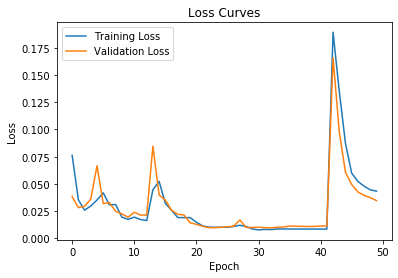

In [53]:
plt.plot(np.arange(n_epochs), loss, label='Training Loss')
plt.plot(np.arange(n_epochs), val_loss, label='Validation Loss')
plt.title('Loss Curves')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')

## Run prediction on test data

In [54]:
classes = model.predict(test_data)

(array([4.925e+03, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 1.000e+00, 1.000e+00, 6.070e+03]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ],
       dtype=float32),
 <a list of 10 Patch objects>)

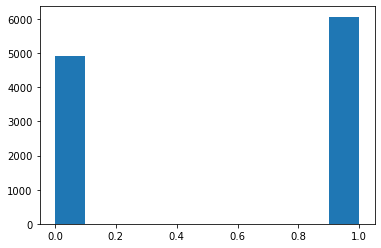

In [55]:
plt.hist(classes[:,1])

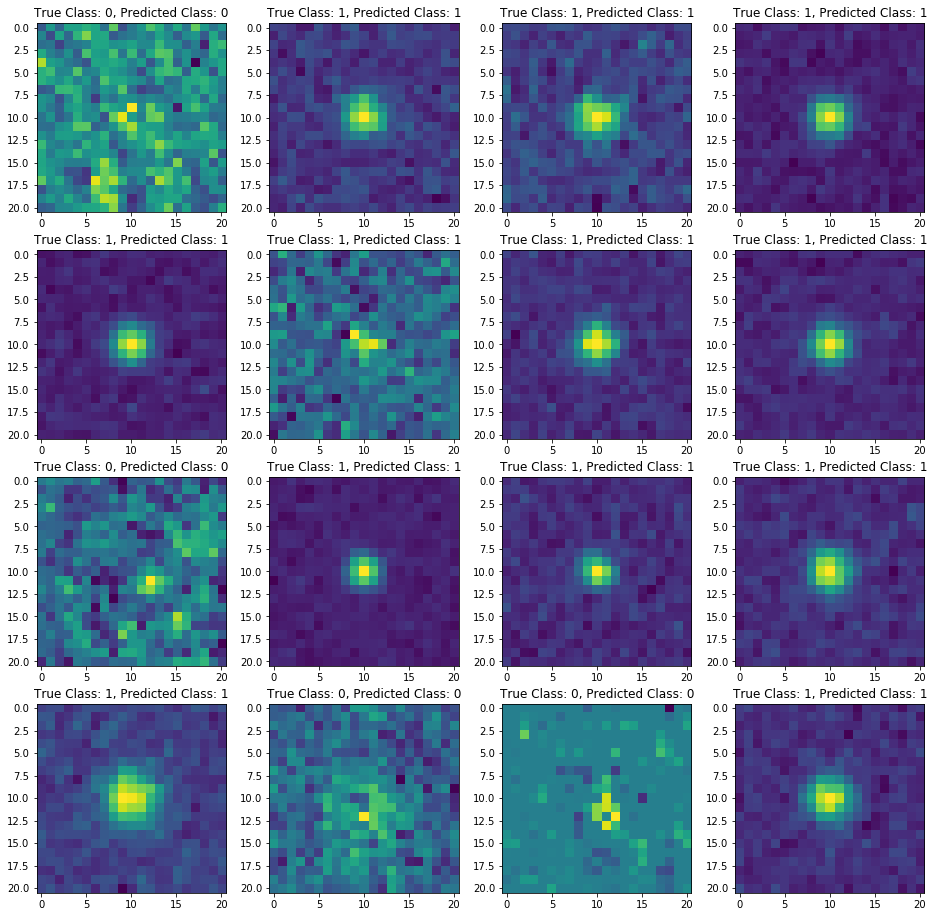

In [56]:
fig = plt.figure(figsize=(16, 16))
for i in range(16):
    fig.add_subplot(4,4,i+1)
    plt.imshow(test_data[i].reshape(21,21))
    plt.title('True Class: %i, Predicted Class: %i' % (np.argmax(test_class[i]), np.argmax(classes[i])))

In [57]:
correct_false = []
correct_true = []
false_positive = []
false_negative = []
index = 0
cutoff = 0.5
for true_class, result_prob in zip(test_class, classes):
    if np.argmax(true_class) == 0.:
        if result_prob[0] > cutoff:
            correct_false.append(index)
        else:
            false_positive.append(index)
    else:
        if result_prob[0] > cutoff:
            false_negative.append(index)
        else:
            correct_true.append(index)
    index+=1

In [58]:
keras_results = np.array([[len(correct_true), len(false_positive)], [len(false_negative), len(correct_false)]])

In [59]:
keras_results

array([[6040,   33],
       [  10, 4916]])

(2, 0)

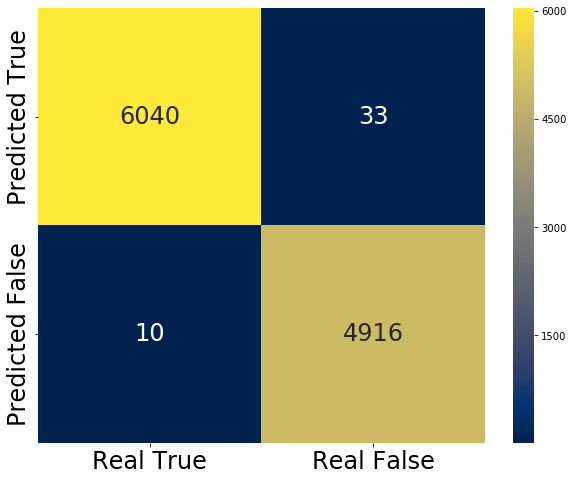

In [60]:
fig = plt.figure(figsize=(10,8))
sns.heatmap(keras_results, annot=True, annot_kws={'size':24}, cmap=plt.get_cmap('cividis'), fmt='g')
plt.xticks([0.5, 1.5], ['Real True', 'Real False'], size=24)
plt.yticks([0.5, 1.5], ['Predicted True', 'Predicted False'], size=24, va='center')
plt.ylim(2, 0)

### Look at False Negatives and False Positives

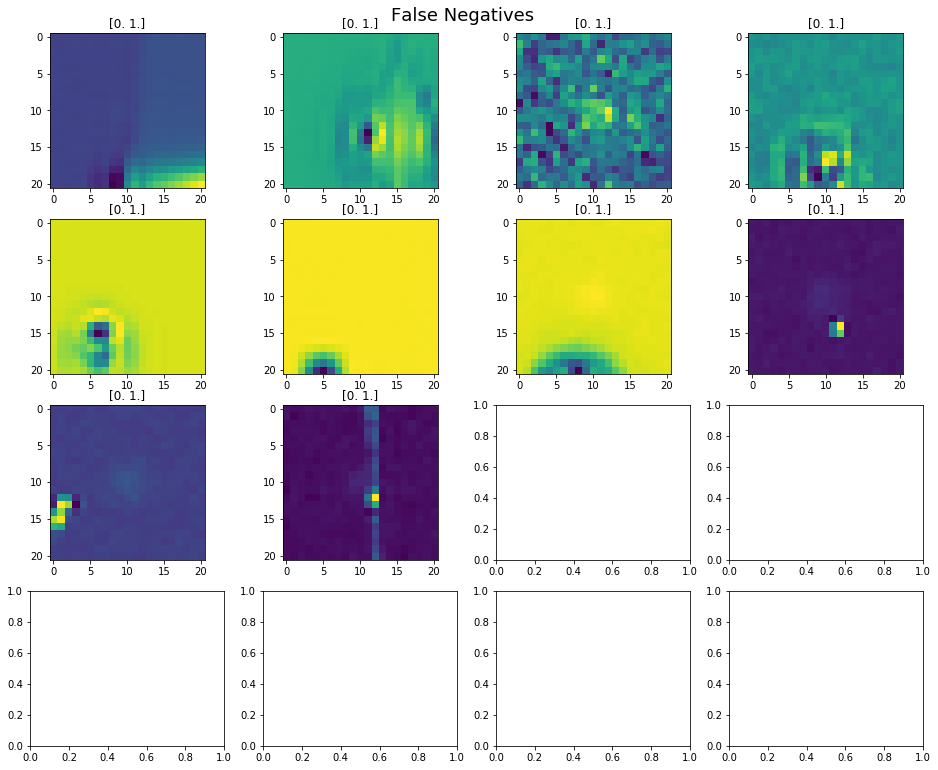

In [61]:
fig = plt.figure(figsize=(16, 12))
for i in range(16):
    try:
        fig.add_subplot(4, 4, i+1)
        plt.imshow(test_data[false_negative[i]].reshape(21,21))
        plt.title(test_class[false_negative[i]])
    except:
        continue
plt.suptitle('False Negatives', size=18)
plt.subplots_adjust(top=0.95)

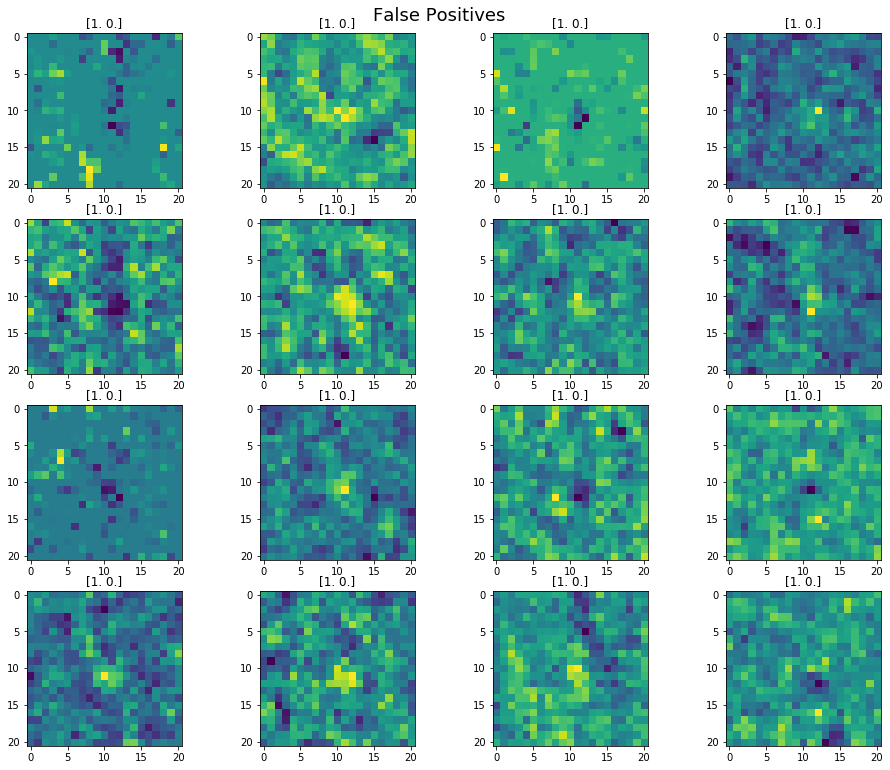

In [62]:
fig = plt.figure(figsize=(16, 12))
for i in range(16):
    try:
        fig.add_subplot(4, 4, i+1)
        plt.imshow(test_data[false_positive[i]].reshape(21,21))
        plt.title(test_class[false_positive[i]])
    except:
        continue
plt.suptitle('False Positives', size=18)
plt.subplots_adjust(top=0.95)

## Save Model

In [63]:
filename = 'keras_kbmod.h5'
model.save(filename)